## Parcel model with 30 aerosol masses, lognormal distribution

In [1]:
from importlib import reload
import ruamel.yaml as ry
import a405utils
from pathlib import Path
import numpy as np
from a405dropgrow.aerolib import lognormal,create_koehler
from a405utils.helper_funs import make_tuple, find_centers
from collections import OrderedDict as od
from a405thermo.thermlib import find_esat,find_thetaet,tinvert_rsat,find_Td,find_rsat,find_lv
from a405thermo.rootfinder import find_interval, fzero
import a405dropgrow.drop_grow
reload(a405dropgrow.drop_grow)
from a405dropgrow.drop_grow import find_diff, wlcalc, find_derivs, Scalc
from a405thermo.constants import constants as c
from scipy.integrate import odeint
import pandas as pd
from matplotlib import pyplot as plt
import datetime, h5py

### Read in the yaml file and set the koehler function for this aerosol

In [2]:
util_dir, = a405utils.__path__._path
data_dir = Path(util_dir).joinpath('../data')
yaml_file = data_dir.joinpath('dropgrow.yaml')
with yaml_file.open('r') as f:
    input_dict=ry.load(f,Loader=ry.RoundTripLoader)

aero=make_tuple(input_dict['aerosol'])
parcel=make_tuple(input_dict['initial_conditions'])

koehler_fun = create_koehler(aero,parcel)
    

### initialize the lognormal mass and number distributions for 30 bins

In [3]:
#
#set the edges of the mass bins
#31 edges means we have 30 droplet bins
#
numrads = 30
mass_vals = np.linspace(-20,-16,numrads+1) 
mass_vals = 10**mass_vals  #aerosol mass in kg
mu=input_dict['aerosol']['themean']
sigma = input_dict['aerosol']['sd']
totmass = input_dict['aerosol']['totmass']
mdist = totmass*lognormal(mass_vals,np.log(mu),np.log(sigma))
mdist = find_centers(mdist)*np.diff(mass_vals)  #kg/m^3 of aerosol in each bin
center_mass = find_centers(mass_vals)
ndist = mdist/center_mass  #number/m^3 of aerosol in each bin
#save these in an ordered dictionary to pass to functions
cloud_vars = od()
cloud_vars['mdist'] = mdist
cloud_vars['ndist'] = ndist
cloud_vars['center_mass'] = center_mass
cloud_vars['koehler_fun'] = koehler_fun

### find the equilibrium radius for each bin at saturation Sinit

In [4]:
S_target = parcel.Sinit
logr_start = np.log(0.1e-6)

initial_radius = []
dry_radius = []
for mass in center_mass:
    brackets = np.array(find_interval(find_diff,logr_start,S_target,mass,koehler_fun))
    left_bracket, right_bracket = np.exp(brackets)*1.e6  #get brackets in microns for printing
    equil_rad = np.exp(fzero(find_diff,brackets,S_target,mass,koehler_fun))

    initial_radius.append(equil_rad)
    dry_rad = (mass/(4./3.*np.pi*aero.rhoaero))**(1./3.)
    dry_radius.append(dry_rad)

    print('mass = {mass:6.3g} kg'.format_map(locals()))
    print('equlibrium radius at S={} is {:5.3f} microns\n'.format(S_target,equil_rad*1.e6))

mass = 1.18e-20 kg
equlibrium radius at S=0.995 is 0.026 microns

mass = 1.6e-20 kg
equlibrium radius at S=0.995 is 0.030 microns

mass = 2.18e-20 kg
equlibrium radius at S=0.995 is 0.035 microns

mass = 2.96e-20 kg
equlibrium radius at S=0.995 is 0.040 microns

mass = 4.03e-20 kg
equlibrium radius at S=0.995 is 0.046 microns

mass = 5.48e-20 kg
equlibrium radius at S=0.995 is 0.053 microns

mass = 7.44e-20 kg
equlibrium radius at S=0.995 is 0.061 microns

mass = 1.01e-19 kg
equlibrium radius at S=0.995 is 0.071 microns

mass = 1.38e-19 kg
equlibrium radius at S=0.995 is 0.081 microns

mass = 1.87e-19 kg
equlibrium radius at S=0.995 is 0.093 microns

mass = 2.54e-19 kg
equlibrium radius at S=0.995 is 0.106 microns

mass = 3.45e-19 kg
equlibrium radius at S=0.995 is 0.121 microns

mass = 4.7e-19 kg
equlibrium radius at S=0.995 is 0.138 microns

mass = 6.38e-19 kg
equlibrium radius at S=0.995 is 0.157 microns

mass = 8.68e-19 kg
equlibrium radius at S=0.995 is 0.178 microns

mass = 1.18e

### now add the intial conditions to the cloud_vars dictionary and make it a namedtuple

the vector var_vec holds 30 droplet radii plus three extra variables at the
end of the vector: the temperature, pressure and height.

In [5]:
cloud_vars['initial_radiius'] = initial_radius
cloud_vars['dry_radius'] = dry_radius
cloud_vars['masses'] = center_mass
numrads = len(initial_radius)
var_vec = np.empty(numrads + 3)
for i in range(numrads):
    var_vec[i] = initial_radius[i]

#
# temp, press and height go at the end of the vector
#
var_vec[-3] = parcel.Tinit
var_vec[-2] = parcel.Pinit
var_vec[-1] = parcel.Zinit

cloud_tup = make_tuple(cloud_vars)
#calculate the total water (kg/kg)
wl=wlcalc(var_vec,cloud_tup);
e=parcel.Sinit*find_esat(parcel.Tinit);
wv=c.eps*e/(parcel.Pinit - e)
#save total water
cloud_vars['wt'] = wv + wl
cloud_vars['wvel'] = parcel.wvel
#cloud_vars['wvel'] = 1.5 ###########################
#
# pass this to the find_derivs function
#
cloud_tup= make_tuple(cloud_vars)

### use odeint to integrate the variable in var_vec from tinit to tfin with outputs every dt seconds

In [6]:
var_out = []
time_out =[]

tinit=input_dict['integration']['dt']
dt = input_dict['integration']['dt']
tfin = input_dict['integration']['tend']

t = np.arange(0,tfin,dt)
sol = odeint(find_derivs,var_vec, t, args=(cloud_tup,))

### create a dataframe with 33 columns to hold the data

In [7]:
colnames = ["r{}".format(item) for item in range(30)]
colnames.extend(['temp','press','z'])
df_output = pd.DataFrame.from_records(sol,columns = colnames)

### store the dataframe in an hdf file, including a copy of dropgrow.yaml for reference

In [8]:
if input_dict['dump_output']:
    with pd.HDFStore(input_dict['output_file'],'w') as store:
        store.put(input_dict['frame_name'],df_output,format='table')

#
# turn the input_dict back into yaml, store in a string instead of a file
#
    yaml_string = ry.dump(input_dict,None,Dumper=ry.RoundTripDumper,
                           default_flow_style=False)
#
# write the string out as an hdf5 attribute, along with a history comment
#
    with h5py.File(input_dict['output_file'],'a') as f:
        f.attrs['yaml_string']=yaml_string
        date=datetime.datetime.now().strftime('%Y-%M-%d')
        history ="file produced by drop_grow.py on {}".format(date)
        print('history: ',history)
        f.attrs['history']=history

history:  file produced by drop_grow.py on 2016-15-13


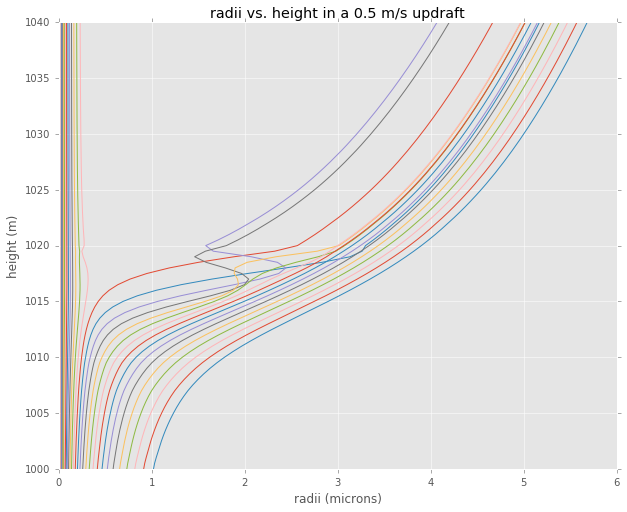

In [9]:
%matplotlib inline
plt.style.use('ggplot')
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=[10,8])
for i in colnames[:-3]:
    ax.plot(df_output[i]*1.e6,df_output['z'],label=i)
out=ax.set(ylim=[1000,1040],xlim=[0,6],
       xlabel='radii (microns)',ylabel='height (m)',
              title='radii vs. height in a {} m/s updraft'.format(cloud_tup.wvel))

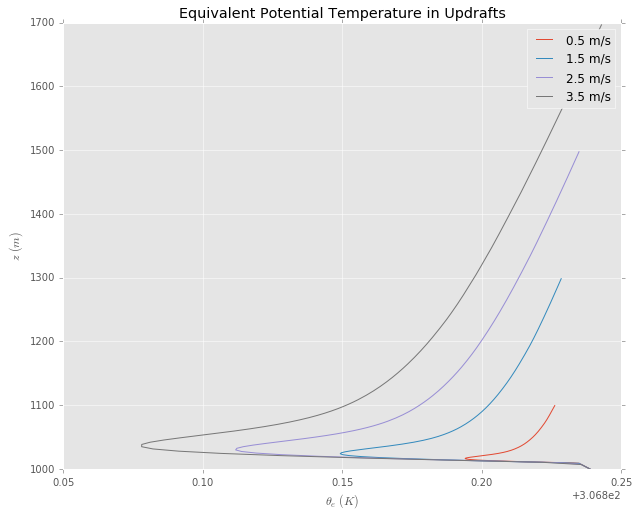

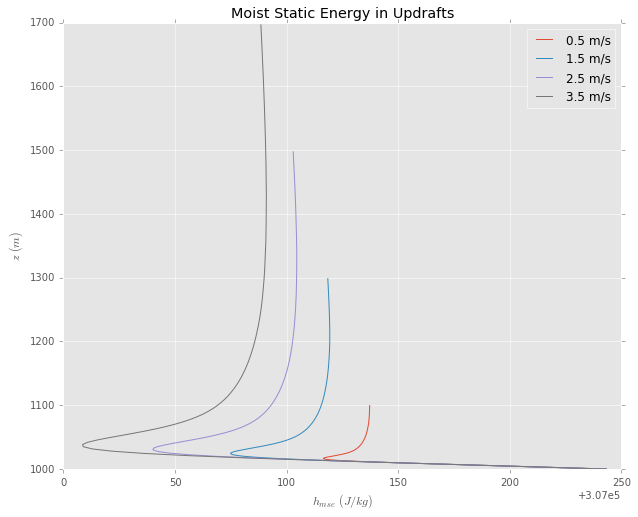

In [10]:
cp = 1000.
grav = 9.81

# set updraft velocities
wvels = [0.5, 1.5, 2.5, 3.5]

fig1,ax1 = plt.subplots(1,1,figsize=[10,8])
fig2,ax2 = plt.subplots(1,1,figsize=[10,8])

# loop over wvels and redo integration
for wvel in wvels:
    cloud_vars['wvel'] = wvel
    cloud_tup= make_tuple(cloud_vars)
    
    var_vec = np.empty(numrads + 3)
    for i in range(numrads):
        var_vec[i] = initial_radius[i]

    #
    # temp, press and height go at the end of the vector
    #
    var_vec[-3] = parcel.Tinit
    var_vec[-2] = parcel.Pinit
    var_vec[-1] = parcel.Zinit

    sol = odeint(find_derivs,var_vec, t, args=(cloud_tup,))
    
    df_output = pd.DataFrame.from_records(sol,columns = colnames)

    # set label for plotting
    label_str = "{} m/s".format(wvel)
    
    # initialize lists for plotting
    thetae = []
    mse = []
    
    for index,row in df_output.iterrows():
        var_vec = row.values
        rsat = find_rsat(row.temp, row.press) # calculate rsat
        rv = Scalc(var_vec,cloud_tup)*rsat # calculate rv from rsat and Sval
        tdew = find_Td(rv, row.press) # calculate the dew point
        thetae.append(find_thetaet(tdew, rv, row.temp, row.press))
        mse.append(cp*row.temp + find_lv(row.temp)*rsat + grav*row.z)
        
    # plot thetae and mse for current wvel  
    ax1.plot(thetae, df_output.z, label=label_str)
    ax2.plot(mse, df_output.z, label=label_str)

ax1.legend()
ax1.set_xlabel(r"$\theta_e\ (K)$")
ax1.set_ylabel(r"$z\ (m)$")
ax1.set_title("Equivalent Potential Temperature in Updrafts")
ax2.legend()
ax2.set_xlabel(r"$h_{mse}\ (J/kg)$")
ax2.set_ylabel(r"$z\ (m)$")
ax2.set_title("Moist Static Energy in Updrafts")

# variables are not conserved, since they are only conserved in adiabatic ascent
# presence of updrafts violates that assumption